In [1]:
import numpy as np
import pandas as pd 

# Listing current data on our folder.
import os


['.ipynb_checkpoints', 'Untitled.ipynb']


In [16]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(concat_path("./MIDIs", "Queen - Bohemian Rhapsody.mid"), True)
base_midi

  Using cached music21-7.3.3-py3-none-any.whl (22.4 MB)


<music21.stream.Score 0x205bb2b6460>

In [17]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Horn
Alto Saxophone
Piano
Electric Bass
StringInstrument
Choir
Brass
English Horn
Electric Guitar
Electric Guitar
Sampler
Timpani


In [31]:
base_midi.show()

OSError: [WinError 123] 파일 이름, 디렉터리 이름 또는 볼륨 레이블 구문이 잘못되었습니다: 'C:\\Users\\LEE\\python\\MIDI\\C:\\Program Files\\MuseScore 3\\MuseScore.exe'

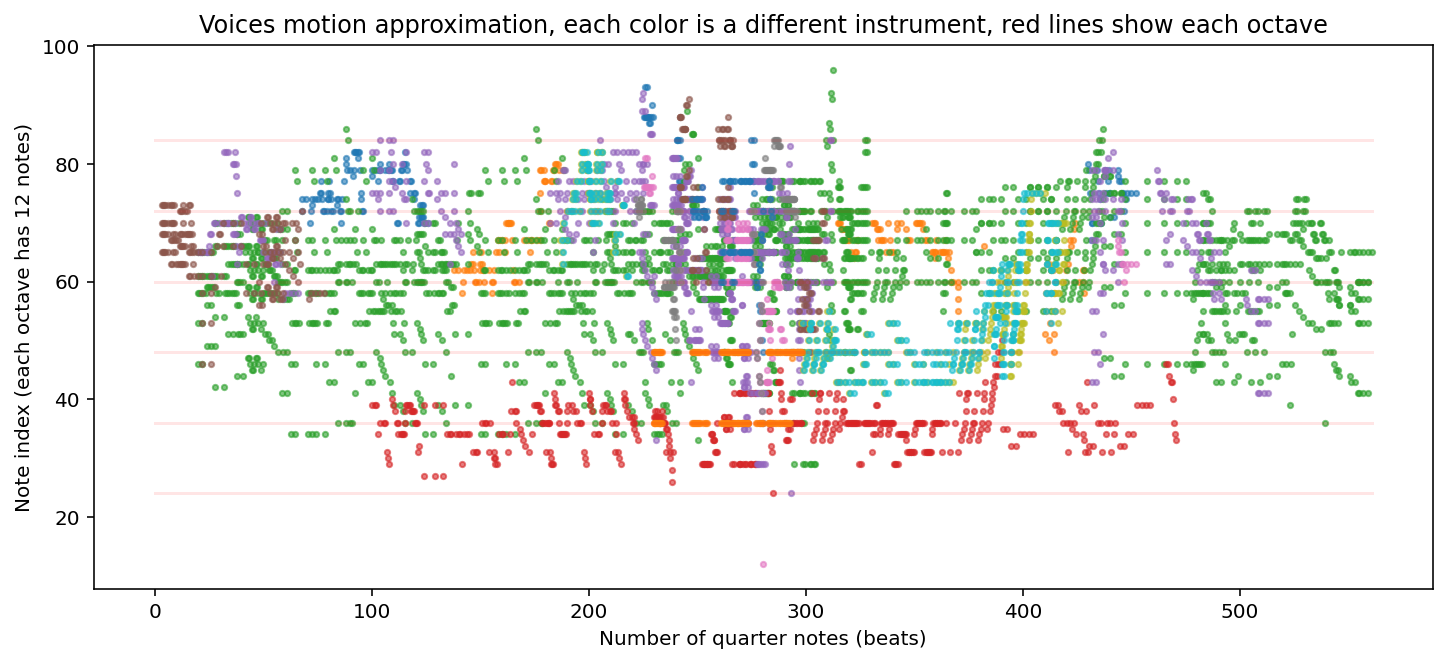

In [30]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0,6000))

<music21.graph.plot.ScatterPitchClassOffset for <music21.stream.Score 0x205bb2b6460>>

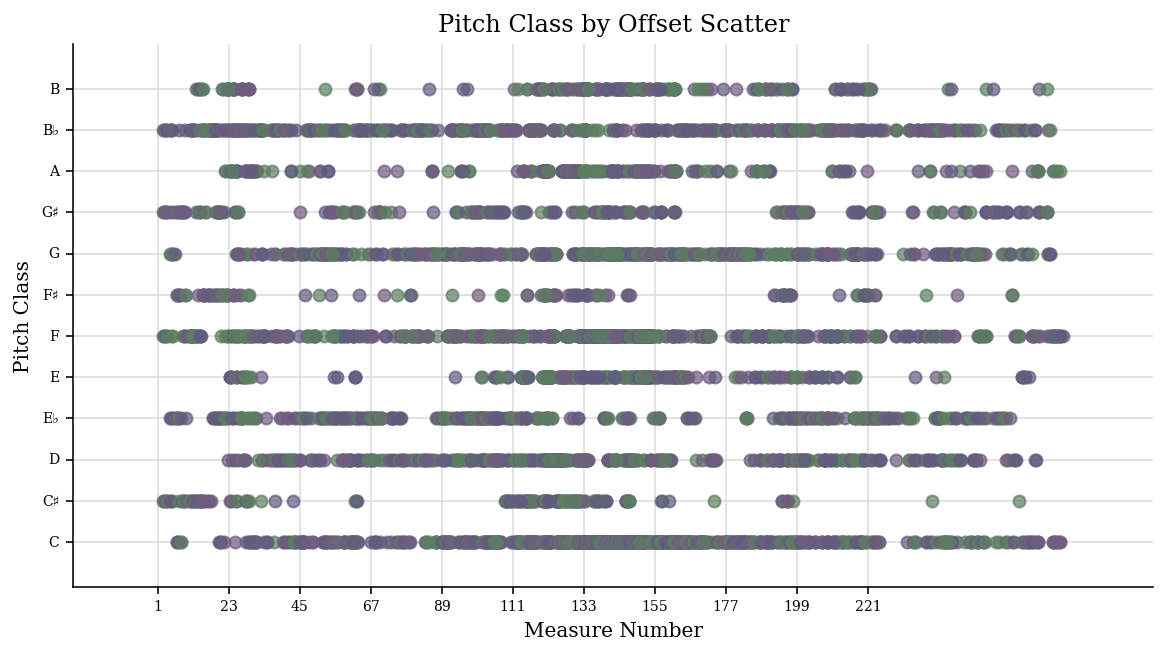

In [22]:
base_midi.plot('scatter', 'offset', 'pitchClass')

In [23]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: c minor
Music key confidence: 0.8163985286067778
Other music key alternatives:
B- major
f minor
E- major
g minor
F major
A- major


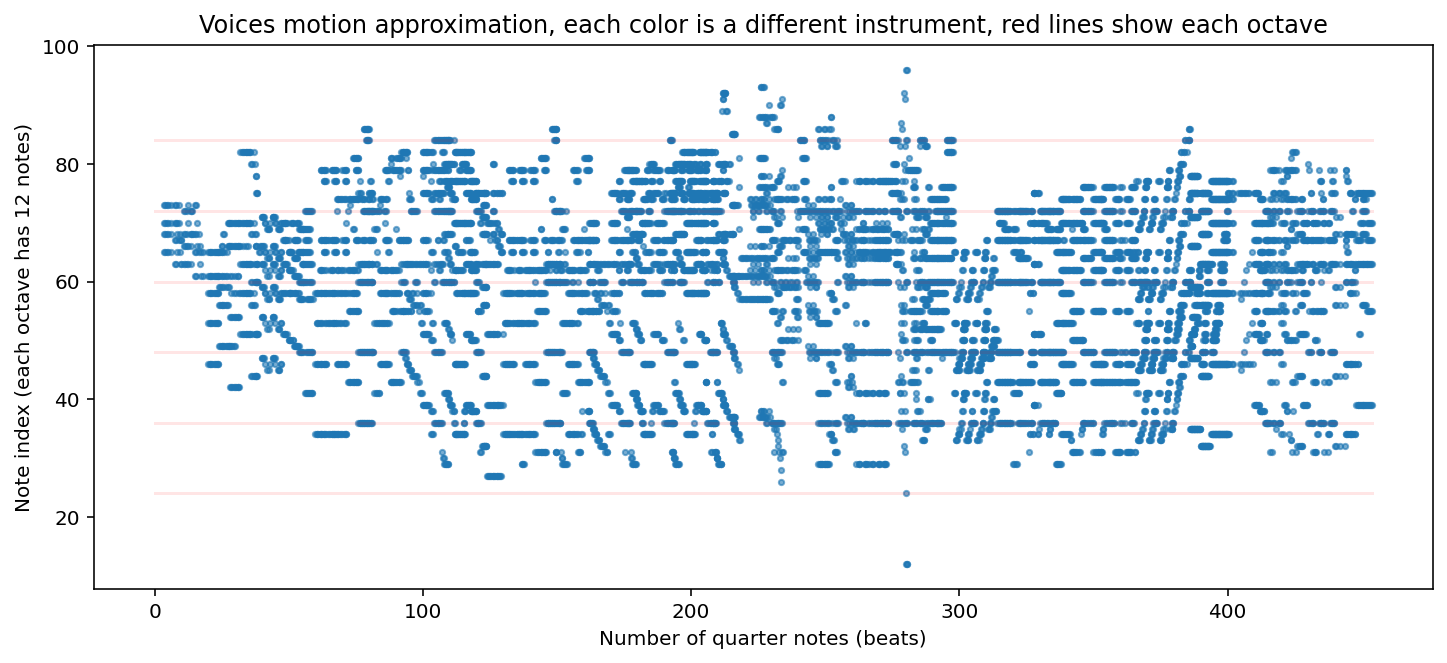

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark andantino Quarter=78.0>
    {0.0} <music21.meter.TimeSignature 2/4>
    {0.0} <music21.note.Rest half>
    {1.25} <music21.instrument.Horn 'Horn'>


In [24]:
from music21 import stream

temp_midi_chords = open_midi(
    concat_path("./MIDIs", "Queen - Bohemian Rhapsody.mid"),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")